In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# for matplotlib backends see: https://matplotlib.org/stable/users/explain/backends.html
# WHEN CHANGING MATPLOTLIB BACKEND, RESTART THE KERNEL

# use inline for basic inline graphs, but no animations
# %matplotlib inline

# use widget for inline animations
%matplotlib widget

# use qt for interactive pop up windows of graphs
# import matplotlib
# matplotlib.use('QtAgg')
# %matplotlib qt

### Define constants

In [15]:
grid_size_x = 15
grid_size_y = 10
grid_values_count = grid_size_x * grid_size_y
rho_0 = 1.

### Intialize arrays

In [16]:
# arrays defined in format row, column
density_values = np.zeros((grid_size_y, grid_size_x))

# at each position in velocity_values is a vector containing one of the directions as defined in c
velocity_values = np.zeros((grid_size_y, grid_size_x, 2), dtype=np.uint8)

# Velocity directions c (defined by [x,y] components)
c_directions = np.array([
                [ 0, 0], # 0 ()
                [ 1, 0], # 1 (right)
                [ 0, 1], # 2 (up)
                [-1, 0], # 3 (left)
                [ 0,-1], # 4 (down)
                [ 1, 1], # 5 (right-up)
                [-1, 1], # 6 (left-up)
                [-1,-1], # 7 (left-down)
                [ 1,-1]  # 8 (right-down)
             ])

# invert the row values for streaming operation because up is represented by -1 and down by 1
c_directions_for_streaming = c_directions * np.array([1, -1])

# 9 because of 9 velocity directions
initial_density_per_position = rho_0 / float(grid_values_count) 
# evenly distribute density in all directions for a grid point
# f_values = np.full((grid_size_y, grid_size_x, 9), initial_density_per_position / 9.)

# density per position is zero except one specified non zero direction (the value refers to the index in c)
f_values = np.zeros((grid_size_y, grid_size_x, 9))
# f_values[:,:,1] = initial_density_per_position
# calculate a "border", which is a vertical line, that seperates two directions
# this enables an initialization which can be used for a quick visual check of the streaming function
inital_border_value = np.rint(grid_size_x/2).astype(np.uint8)
f_values[:, inital_border_value: ,5] = initial_density_per_position * 1/4
f_values[:, :inital_border_value ,1] = initial_density_per_position * 3/4


### Functions

##### Density function

In [17]:
def compute_density(y, x):
    return np.sum(f_values[y,x])

In [18]:
# def compute_all_densities():
#     rows, cols = density_values.shape
#     row_indices = np.arange(rows)
#     col_indices = np.arange(cols)
#     for y in row_indices:
#         for x in col_indices:
#             density_values[y,x] = compute_density(y,x)
            
# # compute_all_densities()

#### Velocity field function

In [19]:
def compute_velocity_field(y,x):

    # TODO: Check if density needs to be stored at all or if only using in formula for new direction
    density = compute_density(y,x)
    density_values[y,x] = density
    # do: [:,np.newaxis] so that broadcasting works
    new_direction = np.sum(f_values[y,x][:,np.newaxis] * c_directions, axis=0) / density
    # numpy rounds 0.5 cases to nearest even value
    x_component, y_component = np.rint(new_direction).astype(np.uint8)

    x_component = 0 if x_component == 0 else (-1 if x_component < 0 else 1)
    y_component = 0 if y_component == 0 else (-1 if y_component < 0 else 1)
    
    # new_direction = np.array([x_component, y_component])
    # # find index of direction in c that resembles the new direction
    # index = np.argwhere((c == new_direction).all(axis=1))[0][0]

    return np.array([x_component, y_component])

In [20]:
def compute_full_velocity_field():
    rows, cols = density_values.shape
    row_indices = np.arange(rows)
    col_indices = np.arange(cols)
    for y in row_indices:
        for x in col_indices:
            velocity_values[y,x] = compute_velocity_field(y,x)

#### Streaming Function

In [21]:
def streaming(): 
    # after_roll = np.roll(test_f_values[:,:,2], shift=(-1,0), axis=(0, 1)) 
    # start at index 1 because direction 0 (0,0) does not change anything with roll call, axis=(1,0) means first in x direction, then in y direction because f is defined by row, column indices 
    # TODO: CHANGE FORMAT OF F FUNCTIONS FROM YXI TO IYX  
    for i in range(1, len(c_directions)): f_values[:,:,i] = np.roll(f_values[:,:,i], shift=c_directions_for_streaming[i], axis=(1, 0))

# test_f_values = np.random.rand(grid_size_y, grid_size_x, 9)
# values_before = test_f_values.copy()
# streaming()

#### Update function that handles going to next time step

In [22]:
def update():
    streaming()
    compute_full_velocity_field()

### Visualization

#### Density plot

In [23]:
def plot_density_field(timestep = None):
    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Get the shape of the 2D array
    y, x = np.meshgrid(np.arange(density_values.shape[0]), np.arange(density_values.shape[1]), indexing="ij")

    # Plot the surface
    ax.plot_surface(x, y, density_values)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    title = "Density field"
    if timestep is not None:
        title += " for t={}".format(timestep)
    ax.set_title(title)

    plt.show()

#### Velocity field plot

In [24]:
def plot_velocity_field(timestep : int = 0, animation_timesteps = 0):
    ani = None

    # define grid of velocity field
    x = np.linspace(0, grid_size_x, grid_size_x)
    y = np.linspace(0, grid_size_y, grid_size_y)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    U = velocity_values[:,:,0]
    V = velocity_values[:,:,1]
    stream = ax.streamplot(X, Y, U, V)
    # ax.quiver(X, Y, c[velocity_values[:,:], 0], c[velocity_values[:,:]) is also a good option
    ax.set_xticks(np.arange(0, grid_size_x, 1))
    ax.set_yticks(np.arange(0, grid_size_y, 1))
    ax.grid()

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    title = "Velocity field for t={}".format(timestep)
    ax.set_title(title)

    if animation_timesteps > 0:
        def animate(i):
            ax.cla()
            update()
            U = velocity_values[:,:,0]
            V = velocity_values[:,:,1]
            stream = ax.streamplot(X, Y, U, V)
            title = "Velocity field for t={}".format(timestep + i)
            ax.set_title(title)
            return stream,
    
        ani = animation.FuncAnimation(fig, animate, frames=animation_timesteps, interval=20, blit=False, save_count=50)

    return ani

### Test

/tmp/ipykernel_3939/1252604423.py:35: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=20.
  ani = animation.FuncAnimation(fig, animate, frames=animation_timesteps, interval=20, blit=False, save_count=50)


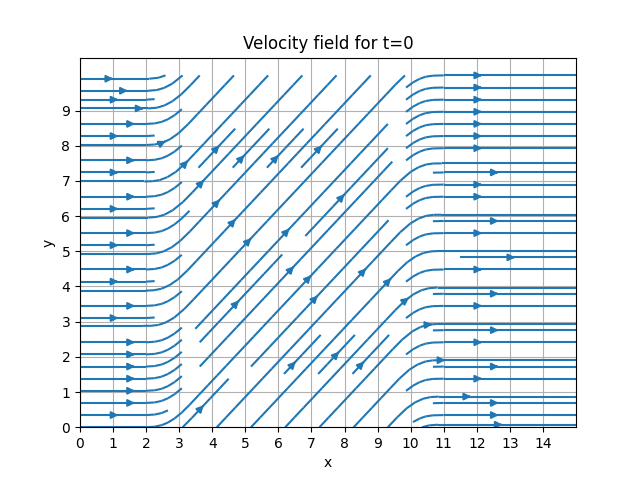

In [25]:
# testing velocity field animation
# compute_full_velocity_field()
# anim = plot_velocity_field(timestep=0, animation_timesteps=20)
# plt.show()

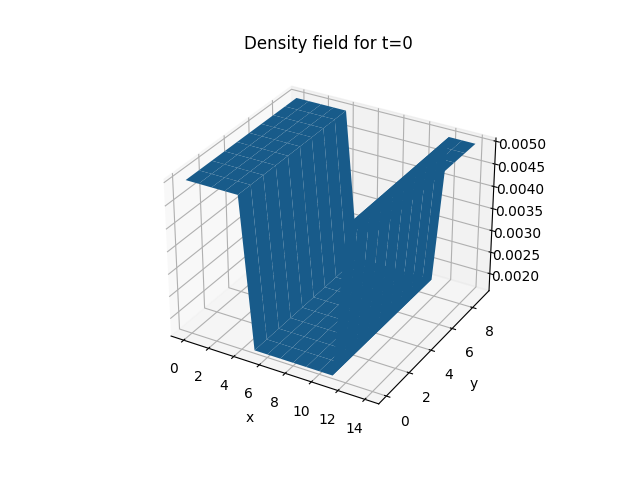

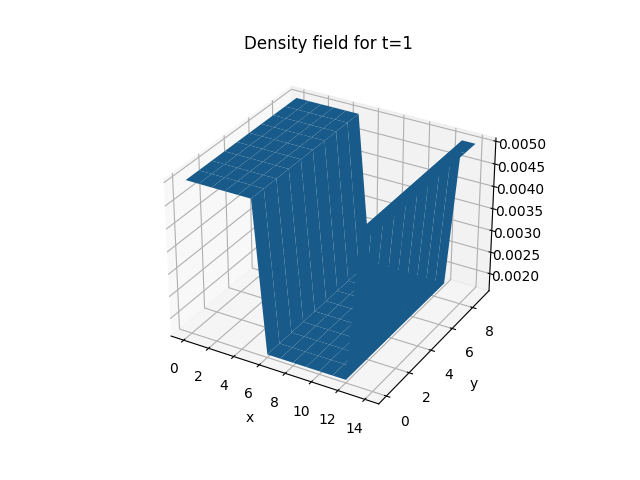

Mass before update = 77.49999999999999
Mass after update = 77.49999999999999


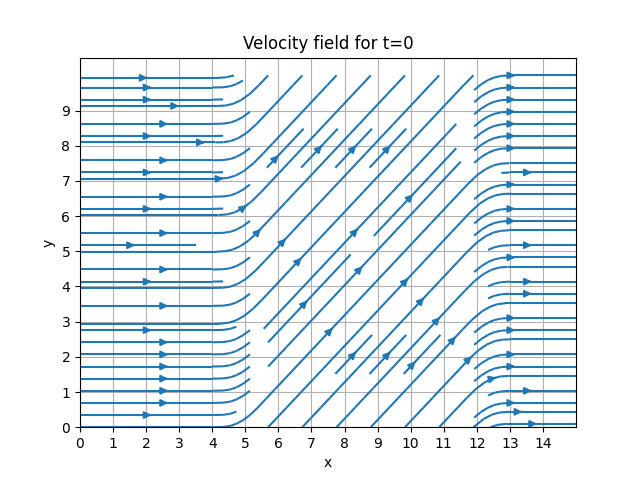

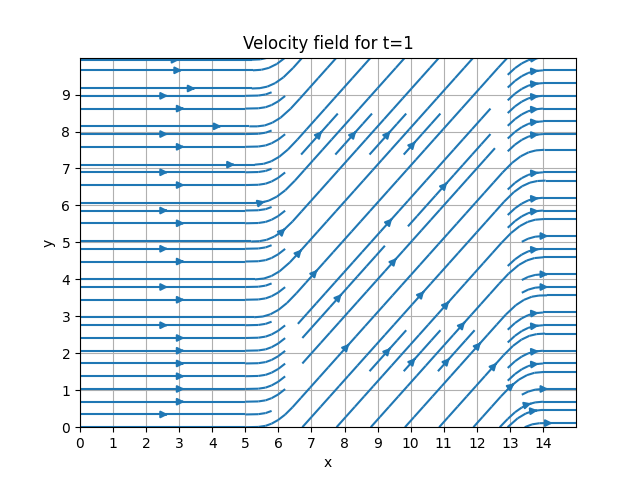

In [26]:
# mass = density * volume
full_volume = grid_values_count

# initial computation of velocity field for visualization
compute_full_velocity_field()
plot_density_field(0)
plot_velocity_field(0)

full_density = np.sum(density_values)
mass_before_update = full_density * full_volume

# do a timestep update and plot
update()
plot_density_field(1)
plot_velocity_field(1)

full_density = np.sum(density_values)
mass_after_update = full_density * full_volume

print("Mass before update = {}".format(mass_before_update))
print("Mass after update = {}".format(mass_after_update))